# EEG Analysis with MNE


**Author**: Angela Renton & Monika Doerig

### Citation:

#### Tools included in this workflow
__MNE-Python__:
- Larson, E., Gramfort, A., Engemann, D. A., Leppakangas, J., Brodbeck, C., Jas, M., Brooks, T. L., Sassenhagen, J., McCloy, D., Luessi, M., King, J.-R., Höchenberger, R., Brunner, C., Goj, R., Favelier, G., van Vliet, M., Wronkiewicz, M., Rockhill, A., Appelhoff, S., … user27182. (2025). MNE-Python (v1.10.0). Zenodo. [https://doi.org/10.5281/zenodo.15928841](https://doi.org/10.5281/zenodo.15928841)
- Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. [doi:10.3389/fnins.2013.00267](https://doi.org/10.3389/fnins.2013.00267)

#### Tutorial this work is based on 
- [Analysing EEG Data with MNE by Angela Renton](https://neurodesk.org/tutorials-examples/tutorials/electrophysiology/eeg_mne-python/)


#### Dataset
- Renton, A. (2022, April 11). Optimising the classification of feature-based attention in frequency-tagged electroencephalography data. [https://doi.org/10.17605/OSF.IO/C689U](https://doi.org/10.17605/OSF.IO/C689U)

#### Check CPU vendor and model for compatibility or performance considerations

In [1]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


## Install and import python libraries

In [2]:
%%capture 
!pip install mne==1.10.0

In [3]:
! python -c "import mne; mne.sys_info()"

Platform             Linux-5.4.0-204-generic-x86_64-with-glibc2.35
Python               3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
Executable           /opt/conda/bin/python
CPU                  Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz (32 cores)
Memory               243.9 GiB

Core
├☑ mne               1.10.0 (latest release)
├☑ numpy             1.26.4 (OpenBLAS 0.3.23.dev with 32 threads)
├☑ scipy             1.13.0
└☑ matplotlib        3.8.4 (backend=module://matplotlib_inline.backend_inline)

Numerical (optional)
├☑ sklearn           1.6.1
├☑ nibabel           5.2.1
├☑ nilearn           0.12.0
├☑ dipy              1.10.0
├☑ pandas            2.2.3
├☑ h5py              3.12.1
└☐ unavailable       numba, openmeeg, cupy, h5io

Visualization (optional)
├☑ vtk               9.3.1
├☑ ipywidgets        8.1.2
└☐ unavailable       pyvista, pyvistaqt, qtpy, ipympl, pyqtgraph, mne-qt-browser, trame_client, trame_server, trame_vtk, trame_vuetify

Ecosystem (

In [4]:
# Import the necessary libraries
import mne
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os 
import numpy as np

## Introduction
In this tutorial, we analyze EEG data from a visual attention task designed to evoke steady-state visual evoked potentials (SSVEPs). The dataset comes from an experiment in which participants viewed flickering fields of black and white dots, each assigned a different flicker frequency (6 Hz or 7.5 Hz, counterbalanced). Before each 15-second trial, participants were cued to attend to one color and detect brief bursts of coherent motion. On half the trials, both colors were presented concurrently (requiring selective attention), while on the other half, only the cued color was shown (mimicking complete attentional suppression). In our analysis, we focus on one participant and examine how attention modulates the frequency-tagged brain responses. After epoching and averaging trials by attended frequency, we use Fourier analysis to visualize how attention enhances SSVEP amplitude at the attended frequency.

### Data download from OSF

In [5]:
# Use the OSF client to fetch the contents of the OSF project with ID 'C689U' into the current directory
# The output is suppressed for cleaner display using > /dev/null 2>&1
!osf -p C689U fetch Data_sample.zip > /dev/null 2>&1

# Extract the contents of the downloaded zip file
! unzip Data_sample.zip

# Remove the 'osfstorage' directory to keep things tidy
!rm -rf osfstorage/

Archive:  Data_sample.zip
   creating: Data_sample/
  inflating: Data_sample/helperdata.asv  
  inflating: Data_sample/helperdata.m  
 extracting: Data_sample/helperdata.mat  
  inflating: Data_sample/participants.json  
  inflating: Data_sample/participants.tsv  
   creating: Data_sample/sourcedata/
   creating: Data_sample/sourcedata/sub-01/
   creating: Data_sample/sourcedata/sub-01/behave/
  inflating: Data_sample/sourcedata/sub-01/behave/sub-01_task-FeatAttnDec_behav.mat  
   creating: Data_sample/sourcedata/sub-01/eeg/
  inflating: Data_sample/sourcedata/sub-01/eeg/sub-01_task-FeatAttnDec_eeg.mat  
   creating: Data_sample/sub-01/
   creating: Data_sample/sub-01/eeg/
  inflating: Data_sample/sub-01/eeg/sub-01_task-FeatAttnDec_channels.tsv  
  inflating: Data_sample/sub-01/eeg/sub-01_task-FeatAttnDec_eeg.eeg  
  inflating: Data_sample/sub-01/eeg/sub-01_task-FeatAttnDec_eeg.json  
  inflating: Data_sample/sub-01/eeg/sub-01_task-FeatAttnDec_eeg.vhdr  
  inflating: Data_sample/sub-01

In [6]:
# Display the folder tree
!tree Data_sample 

Data_sample
├── helperdata.asv
├── helperdata.m
├── helperdata.mat
├── participants.json
├── participants.tsv
├── sourcedata
│   └── sub-01
│       ├── behave
│       │   └── sub-01_task-FeatAttnDec_behav.mat
│       └── eeg
│           └── sub-01_task-FeatAttnDec_eeg.mat
└── sub-01
    └── eeg
        ├── sub-01_task-FeatAttnDec_channels.tsv
        ├── sub-01_task-FeatAttnDec_eeg.eeg
        ├── sub-01_task-FeatAttnDec_eeg.json
        ├── sub-01_task-FeatAttnDec_eeg.vhdr
        ├── sub-01_task-FeatAttnDec_eeg.vmrk
        └── sub-01_task-FeatAttnDec_events.tsv

6 directories, 13 files


### Loading and preparing data
Begin by creating a pointer to the data:


In [7]:
# Load data
sample_data_folder = './Data_sample'
sample_data_raw_file = os.path.join(sample_data_folder, 'sub-01', 'eeg',
                                    'sub-01_task-FeatAttnDec_eeg.vhdr')
raw = mne.io.read_raw_brainvision(sample_data_raw_file , preload=True)

Extracting parameters from ./Data_sample/sub-01/eeg/sub-01_task-FeatAttnDec_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3706303  =      0.000 ...  3088.586 secs...


The raw.info structure contains information about the dataset:

In [8]:
# Display data info
print(raw)
print(raw.info)

<RawBrainVision | sub-01_task-FeatAttnDec_eeg.eeg, 6 x 3706304 (3088.6 s), ~169.7 MiB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Iz, Oz, POz, O1, O2, TRIG
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 6
 projs: []
 sfreq: 1200.0 Hz
>


This dataset does not include a montage. We'll use MNE’s built-in standard 10-20 montage to assign approximate electrode positions:

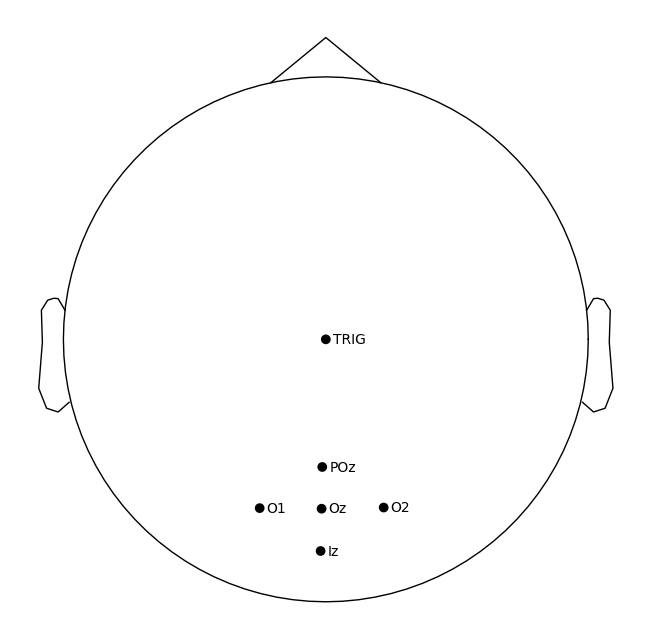

In [9]:
# Use standard montage 
montage_std = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage_std, match_case=False, on_missing='ignore')

# Check how it looks
raw.plot_sensors(kind='topomap', show_names=True)
plt.show() 

Next, let’s visualize the data.

In this notebook, the plot will be rendered as a static image (using Matplotlib as the 2D backend), so interactive features like scrolling through the time series are not available.

Using matplotlib as 2D backend.


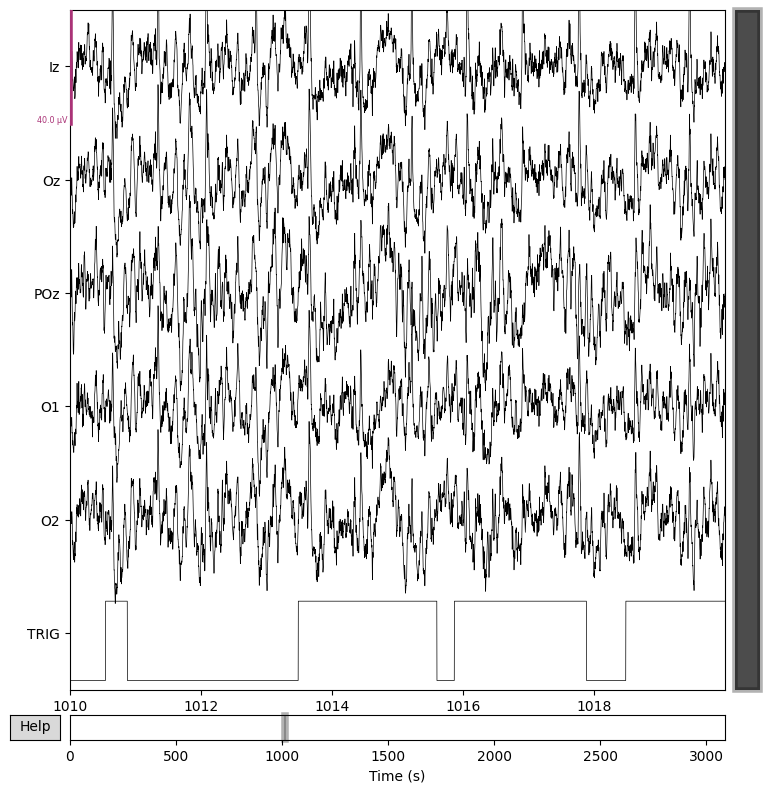

In [10]:
raw.plot(start=1010);

If, upon visual inspection, you decide to exclude one or more channels (e.g., due to noise or signal dropout), you can mark them as "bad" by adding them to `raw.info['bads']`.

For example, to mark channel 'POz' as bad:

In [11]:
raw.info['bads'] = ['POz']

This will ensure that the specified channel is ignored during subsequent preprocessing and analysis steps.

In [12]:
raw.info

<Info | 9 non-empty values
 bads: 1 items (POz)
 ch_names: Iz, Oz, POz, O1, O2, TRIG
 chs: 6 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 6
 projs: []
 sfreq: 1200.0 Hz
>

To visualize the frequency content of the continuous EEG data, use the `compute_psd()` method on the `Raw` object. The resulting `Spectrum` object’s `plot()` method will display the power spectral density (PSD). Since the data contains only EEG channels, the PSD will be shown for those channels.

To plot the average PSD across all EEG channels, use `average=True` and exclude any channels marked as bad.

Effective window size : 1.707 (s)
Plotting power spectral density (dB=True).


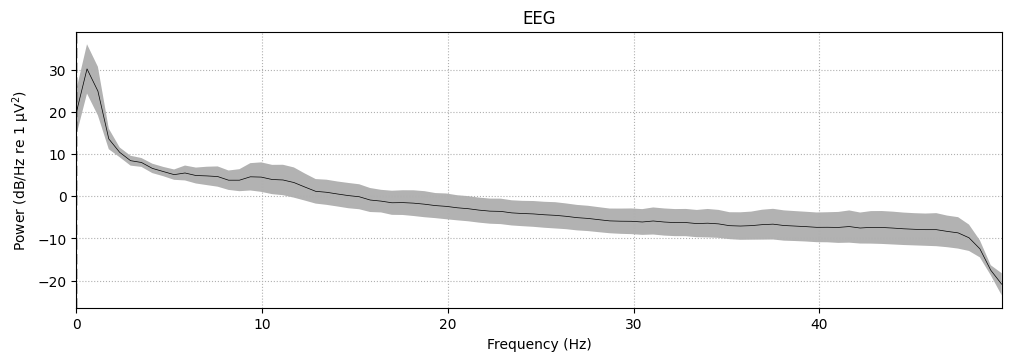

In [13]:
# Now plotting PSD with spatial info should work
spectrum = raw.compute_psd(fmax=50)
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)
plt.show() 

It is also possible to plot each EEG channel individually, with options for how the spectrum should be computed, color-coding the channels by location, and more. 


For example, the following plot shows the PSD of the four selected sensors (specified via the picks parameter), with color-coding by spatial location enabled using the `spatial_colors` parameter. For full details, see the `plot` method [documentation](https://mne.tools/stable/generated/mne.time_frequency.Spectrum.html#mne.time_frequency.Spectrum.plot).

Plotting power spectral density (dB=True).


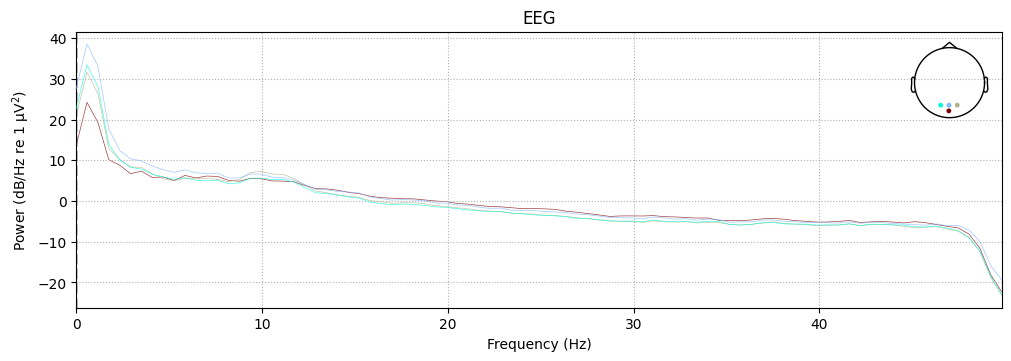

In [14]:
spectrum.plot(picks=["Iz", "Oz", "O1", "O2"], amplitude=False, spatial_colors=True)
plt.show() 

It is also possible to visualize spectral power estimates across sensors as scalp topographies using the Spectrum object’s `plot_topomap()` method. By default, this plots power in five frequency bands (δ, θ, α, β, γ), computes power based on magnetometer channels if available, and displays the estimates on a dB-like logarithmic scale.

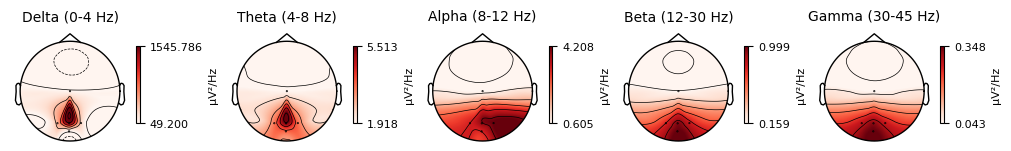

In [15]:
spectrum.plot_topomap()
plt.show() 

### Extract Events
Next, we'll extract events from the trigger channel. Since the trigger channel in this file is incorrectly scaled, we first correct the scaling before extracting the events.

Finding events on: TRIG
1725 events found on stim channel TRIG
Event IDs: [  1   2   3   4   5   6   7   8  21  22  23  24  26  27  28 101 102 104
 106 109 113 117 118 121 122 125 126 129 130]
Found 1725 events, first five:
[[24627     0     4]
 [27040     4    24]
 [29508    24   106]
 [29958   106   126]
 [31968   126   106]]


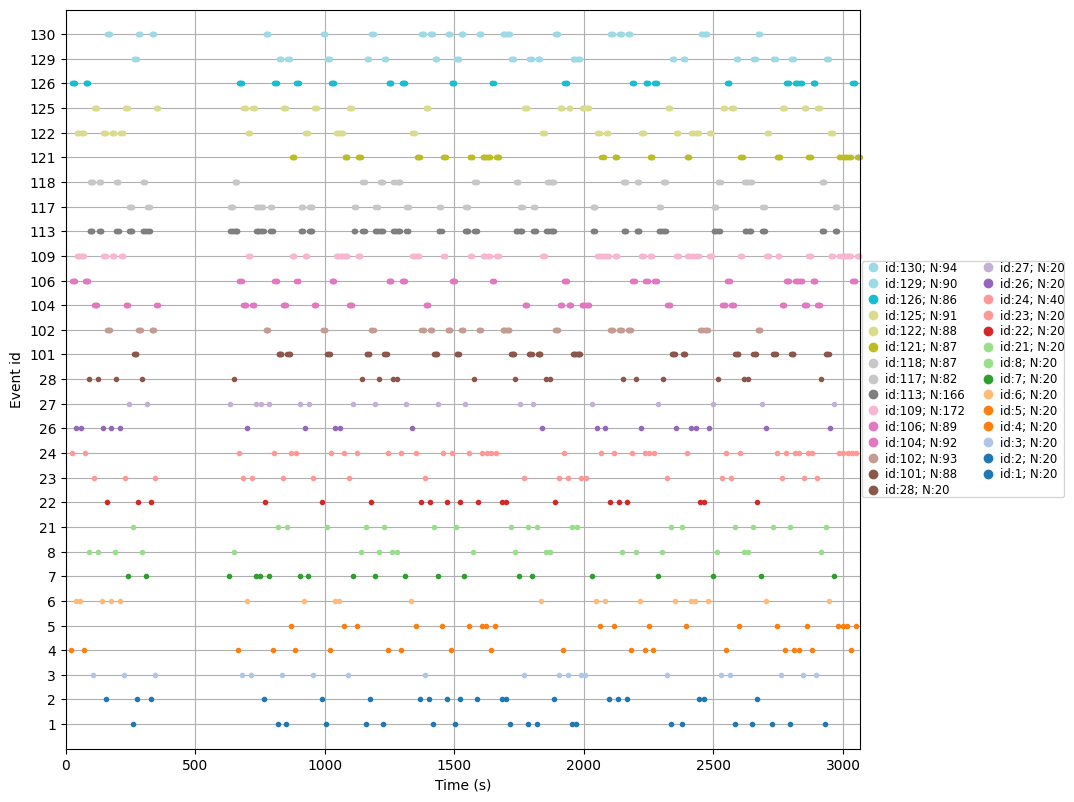

In [16]:
# Correct trigger scaling
trigchan = raw.copy()
trigchan = trigchan.pick('TRIG')
trigchan._data = trigchan._data*1000000 # scale trigger channel properly

# Extract events
events = mne.find_events(trigchan, stim_channel='TRIG', consecutive=True, initial_event=True, verbose=True)
print('Found %s events, first five:' % len(events))
print(events[:5])

# Create colormap
unique_ids = np.unique(events[:, 2])
n_ids = len(unique_ids)
cmap = colormaps['tab20'].resampled(n_ids)

colors = [cmap(i) for i in range(n_ids)]
event_id_to_color = dict(zip(unique_ids, colors))

# Plot events
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=event_id_to_color);
plt.show()

### Extract EEG Channels and Preprocess
Now that we’ve extracted events, we proceed with selecting the EEG channels and applying some simple preprocessing steps.

In [17]:
# Select EEG channels (excluding stimulus channel)
eeg_data = raw.copy().pick_types(eeg=True, exclude=['TRIG'])

# Set montage (should be a properly scaled mne.channels.DigMontage)
eeg_data.info.set_montage(montage_std)

# Interpolate bad channels
eeg_data_interp = eeg_data.copy().interpolate_bads(
    reset_bads=True,
    origin=(0.0, 0.0, 0.0)  # Fix the origin to center of head
)

# # Apply band-pass filter between 1 Hz and 45 Hz
eeg_data_interp.filter(l_freq=1, h_freq=45, h_trans_bandwidth=0.1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Computing interpolation matrix from 4 sensor positions
Interpolating 1 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 45.05 Hz)
- Filter length: 39601 samples (33.001 s)



<RawBrainVision | sub-01_task-FeatAttnDec_eeg.eeg, 5 x 3706304 (3088.6 s), ~141.4 MiB, data loaded>

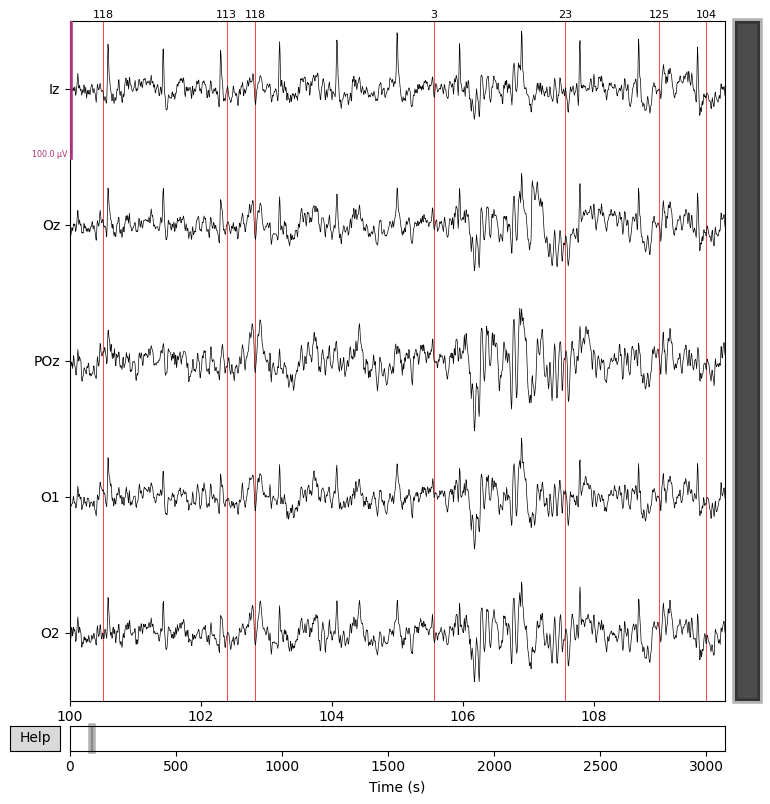

In [18]:
# Plot results again, this time with some events and scaling. 
eeg_data_interp.plot(events=events, 
                     start=100.0,                # seconds into the recording
                     duration=10.0, 
                     scalings=dict(eeg=0.00005), # Adjust EEG amplitude scaling
                     color='k',                  # EEG trace color (black)
                     event_color='r')            # Event markers color (red)
plt.show()

### Epoching the Data
That’s looking good! We can even see hints of the frequency tagging. It’s about time to epoch our data.


In [19]:
# Epoch to events of interest
event_id = {'attend 6Hz K': 23, 'attend 7.5Hz K':  27}  

# Extract 15 s epochs relative to events, baseline correct, linear detrend, and reject 
# epochs where eeg amplitude is > 400
epochs = mne.Epochs(eeg_data_interp, events, event_id=event_id, tmin=0,
                    tmax=15, baseline=(0, 0), reject=dict(eeg=0.000400), detrend=1)  

# Drop bad trials
epochs.drop_bad()

Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 18001 original time points ...
0 bad epochs dropped


<Epochs | 40 events (all good), 0 – 15 s (baseline 0 – 0 s), ~12 KiB, data not loaded,
 'attend 6Hz K': 20
 'attend 7.5Hz K': 20>

We can average these epochs to form Event Related Potentials (ERPs):


combining channels using "mean"
combining channels using "mean"


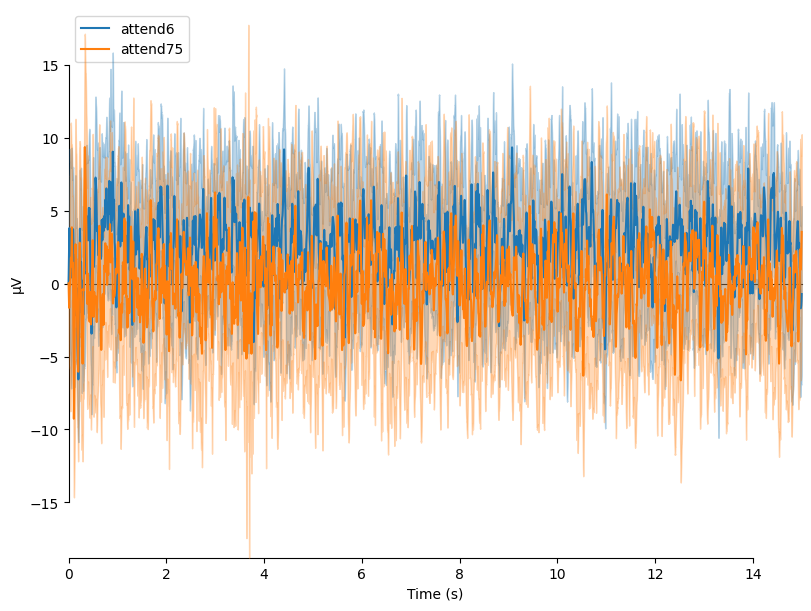

In [20]:
# Average epochs to form ERPs
attend6 = epochs['attend 6Hz K'].average()
attend75 = epochs['attend 7.5Hz K'].average()

# Plot ERPs
evokeds = dict(attend6=list(epochs['attend 6Hz K'].iter_evoked()),
               attend75=list(epochs['attend 7.5Hz K'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean')
plt.show()

In this plot, we can see that the data are frequency tagged. While these data were collected, the participant was performing an attention task in which two visual stimuli were flickering at 6 Hz and 7.5 Hz respectively. On each trial the participant was cued to monitor one of these two stimuli for brief bursts of motion. From previous research, we expect that the steady-state visual evoked potential (SSVEP) should be larger at the attended frequency than the unattended frequency. First, we'll examine how these frequency-tagged responses evolve over time, then quantify their overall strength. Let's check if this is true.

### FFT
Now let's run a fast-fourier transform to evaluate how strongly our two tagged frequencies are represented in each condition. 

In [21]:
duration = 15 # seconds
psds = dict()
for cond in ['attend 6Hz K', 'attend 7.5Hz K']:
    spectrum = epochs[cond].average().compute_psd("welch", n_fft=int(epochs.info['sfreq']*duration), n_overlap=0,
                                                    n_per_seg=int(epochs.info['sfreq']*duration), fmin=4, fmax=17,
                                                    window="boxcar", verbose=False)
    psds[cond], freqs = spectrum.get_data(return_freqs=True)




Finally, let's visualise the results. 

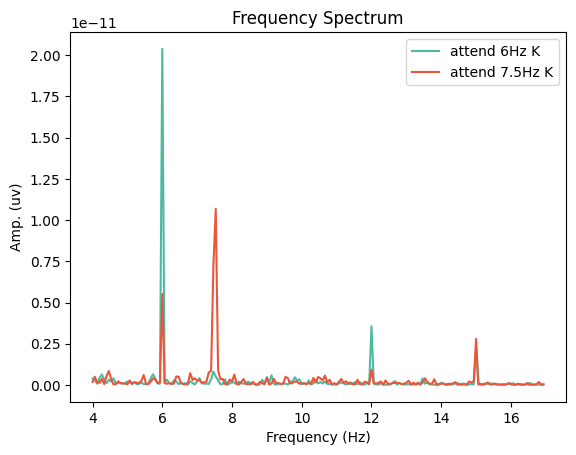

In [30]:
fig,ax = plt.subplots(1, 1)
cols = {'attend 6Hz K':[78 / 255, 185 / 255, 159 / 255], 'attend 7.5Hz K':[236 / 255, 85 / 255, 58 / 255]}

for cond in ['attend 6Hz K', 'attend 7.5Hz K']:
    ax.plot(freqs, psds[cond].mean(axis=0), '-', label=cond, color=cols[cond])
    
ax.set_title('Frequency Spectrum')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amp. (uv)')
ax.legend()
plt.show()

### Exporting the data
Depending on what analyses you have planned, you may wish to extract the data from the mne format to a pandas or numpy array. Here's an example of how we could run the same analysis using numpy and scipy. We’ll begin by exporting the averaged ERP data for each condition to a NumPy array, collapsing across EEG channels:

In [24]:
# Preallocate
n_samples = attend6.data.shape[1]
sampling_freq = attend6.info['sfreq'] # sampling frequency
epochs_np = np.empty((n_samples, 2) )

# Get data - averaging across EEG channels
epochs_np[:,0] = attend6.data.mean(axis=0)
epochs_np[:,1] = attend75.data.mean(axis=0)

Next, we can use a Fast Fourier Transform (FFT) to transform the data from the time domain to the frequency domain. For this, we’ll need to import the FFT packages from scipy:

In [25]:
from scipy.fft import fft, fftfreq, fftshift

# Get FFT
fftdat = np.abs(fft(epochs_np, axis=0)) / n_samples
freq = fftfreq(n_samples, d=1 / sampling_freq)  # get frequency bins

Now that we have our frequency transformed data, we can plot our two conditions to assess whether attention altered the SSVEP amplitudes:

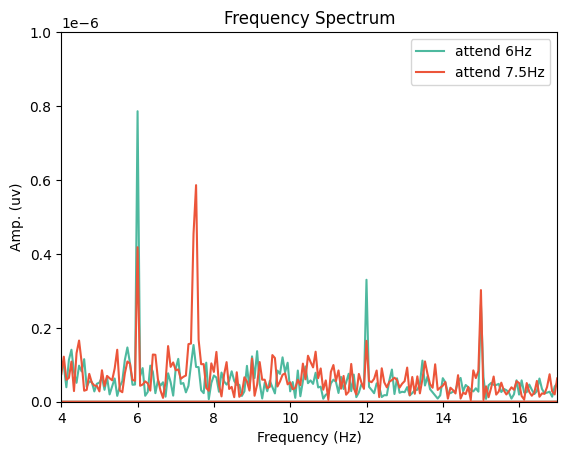

In [26]:
fig,ax = plt.subplots(1, 1)

ax.plot(freq, fftdat[:,0], '-', label='attend 6Hz', color=[78 / 255, 185 / 255, 159 / 255])  
ax.plot(freq, fftdat[:,1], '-', label='attend 7.5Hz', color=[236 / 255, 85 / 255, 58 / 255])  
ax.set_xlim(4, 17)
ax.set_ylim(0, 1e-6)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amp. (uv)')
ax.set_title('Frequency Spectrum')
ax.legend()
plt.show()

This plot shows that the SSVEPs were indeed modulated by attention in the direction we would expect!